In [1]:
import sys; sys.path.append('..')
from about_time import about_time  # ❯ pip install about-time

from brain.sdk import BrainClient

In [2]:
brain = BrainClient("http://127.0.0.1:8000")

# Basic Usage

**Reasoner** 
- Systems that analyze input and provide meaningful output.
- Use the `@reasoner` decorator on a Python function that returns a system prompt and user prompt.
- Responses are formatted according to the attached schema.

In [3]:
from pydantic import BaseModel, Field


class AnswerSchema(BaseModel):
    answer:str
    explanation:str


# Attach tags or pass optional name to the reasoner
@brain.reasoner(name="Sample Reasoner",schema=AnswerSchema,tags=["sample","quick-start"])
def sample_reasoner(system_prompt, user_prompt):
    return dict(system_prompt=system_prompt, user_prompt=user_prompt)

brain.list_reasoners()

                                Reasoners in Project: Default Project                                 
                                                                                                      
  Reasoner          ID                                     Tags                      Created At       
 ──────────────────────────────────────────────────────────────────────────────────────────────────── 
  Sample Reasoner   778e682c-1653-4bd2-854a-eb9d844e57f5   sample, quick-start   2024-12-03 03:14:53  
                                                                                                      
  foo               f7132eac-27eb-40f0-bae5-90a89d81aac6                         2024-12-03 03:14:50  
                                                                                                      
  foo               72b046bd-8053-4dc9-833e-380ea3928597                         2024-12-03 03:14:50  
                                                                                                      
  foo               1049fa58-a281-42f5-91f8-48af2bcbf135                         2024-12-03 03:14:47  
                                                                                                      
  foo               d6290189-d78d-40b1-9335-33289ed7569b                         2024-12-03 03:14:47

We run the reasoner via their ID, this is so that we can swap out the implementation of the reasoner without changing the code that uses it in real-time.

In [4]:
question = "How many R's are there in the word 'STRAWBERRY'?"

with about_time() as t_sync:
    answer_sync = brain.use(sample_reasoner.id)(
        system_prompt="You are an expert letter counter, answer this question",
        user_prompt=question,
    )
    
with about_time() as t_async:
    fut=[]
    for _ in range(5):
        fut.append(brain.use(sample_reasoner.id,run_async=True)(
            system_prompt="You are an expert letter counter, answer this question",
            user_prompt=question,
        ))
    answer_async = [f.result() for f in fut]
    

print("\033[4m1 synchronous call\033[0m")
print(f"Time Taken: {t_sync.duration_human}")
print(f"Answer: {answer_sync}")
print("\n" + "-" * 50 + "\n")
print("\033[4m5 asynchronous calls\033[0m")
print(f"Total Time Taken for 5 async calls: {t_async.duration_human}")
for idx, ans in enumerate(answer_async, start=1):
    print(f"{idx}. Answer: {ans}")

1 synchronous call
Time Taken: 818.1ms
Answer: answer='2' explanation="The word 'STRAWBERRY' contains two instances of the letter 'R'."

--------------------------------------------------

5 asynchronous calls
Total Time Taken for 5 async calls: 680.6ms
1. Answer: answer='2' explanation="The word 'STRAWBERRY' contains two instances of the letter 'R'."
2. Answer: answer='2' explanation="The word 'STRAWBERRY' contains two occurrences of the letter 'R'."
3. Answer: answer='2' explanation="In the word 'STRAWBERRY', there are two occurrences of the letter 'R'."
4. Answer: answer='2' explanation="The word 'STRAWBERRY' contains two 'R's. They appear as the fifth and sixth letters in the word."
5. Answer: answer='2' explanation="The word 'STRAWBERRY' contains two occurrences of the letter 'R'."


## Multiagents

- Encapsulate multiple reasoners.
- Combine outputs of multiple reasoners into a single workflow.
- Do not have a schema.
- Decorated with the `@multi_agent` decorator.
- Define complex units of work requiring multiple specialized reasoners.

### The story writer

In [11]:
from typing import List

from pydantic import BaseModel, Field


# Define schemas for reasoners
class Story(BaseModel):
    story_next_lines: str = Field(..., description="Continuation of the story. Do not repeat the story in the prompt, just provide the continuation.")

class Character(BaseModel):
    name: str = Field(..., description="The name of the character.")
    description: str = Field(..., description="The detailed description of the character and their role in the story.")

class Action(BaseModel):
    type: str = Field(..., description=f"The type of action to take. One of given actions.")
    action_description: str = Field(..., description="suggested continuation or action for the story.")

# Define reasoners
@brain.reasoner(schema=Story)
def story_extender(story: str, action: str):
    """Extends the story based on the provided action."""
    system_prompt = "You are a skilled storyteller."
    user_prompt = (
        f"The current story is:\n{story}\n"
        f"Based on the action '{action}', give a short (~1-3 lines) continuation to the story. If the action is 'end_story', conclude the story gracefully."
    )
    return user_prompt, system_prompt

@brain.reasoner(schema=Character)
def character_describer(name: str, story: str):
    """Introduces a character based on the current story context."""
    system_prompt = "You are a creative writer."
    user_prompt = (
        f"The current story is:\n{story}\n"
        f"Introduce the character named {name} into the story. Use their personality and traits to make their role meaningful."
    )
    return user_prompt, system_prompt

@brain.reasoner(schema=Action)
def action_extender(story: str, actions: List[str]):
    """Suggests the next action for the story."""
    system_prompt = "You are a narrative strategist."
    user_prompt = (
        f"The current story is:\n{story}\n"
        f"Suggest the next action for the story.Based on existing story, choose one of the following that would be the best next step"
        f"\nActions:{actions+['introduce character']}."
        "Clearly state the action type and provide the next_action description."
    )
    return user_prompt, system_prompt

Let's define the multiagent that will use all these reasoners above to generate an interesting story

In [33]:
from random import choice
from typing import List


@brain.multi_agent(name="Story Builder", tags=["storytelling","quick-start"])
def story_builder(start: str, characters: List[str],actions=List[str], n: int = 5):
    """
    Builds a story iteratively by introducing characters and progressing actions.

    Args:
        start (str): The starting line of the story.
        characters (List[str]): List of character names to introduce dynamically.
        n (int): Maximum number of iterations to build the story.

    Returns:
        dict: The final story, introduced characters, remaining characters, and final action.
    """
    story = start
    introduced_characters = []  # Track introduced characters
    remaining_characters = characters[:]  # Characters not yet introduced
    actions_proposed=[]
    
    for _ in range(n-1):
        # Step 1: Determine the next action
        action = brain.use(action_extender.id)(story=story,actions=actions)
        actions_proposed.append(action)
        
        if action.type == "introduce character" and remaining_characters:
            # Introduce a random character
            character_name = choice(remaining_characters)
            
            remaining_characters.remove(character_name)
            character_description = brain.use(character_describer.id)(name=character_name, story=story).description
            story += brain.use(story_extender.id)(story=story, action=f"Introduce {character_name}: {character_description}").story_next_lines
            introduced_characters.append(character_name)

        else:
            story += brain.use(story_extender.id)(story=story, action=f"Type:{action.type} Descprition{action.action_description}").story_next_lines
            

    # Conclude the story
    story += brain.use(story_extender.id)(story=story, action="end_story").story_next_lines

    # Return the final result
    return {
        "final_story": story,
        "introduced_characters": introduced_characters,
        "remaining_characters": remaining_characters,
        "final_action": actions_proposed,
    }

In [34]:
from rich import print

start="Once upon a time, in a faraway land "
characters=["Alice", "Bob", "Charlie", "David", "Eve"]
action=['add happy emotion', 'add sad emotion', 'add twist','make it magical','add fight']
n=6

story=story_builder(start, characters,actions=action, n=n)

print(story)

{
    'final_story': 'Once upon a time, in a faraway land As Eve ventured deeper into the forest, she stumbled upon a
glimmering portal shrouded in vines, pulsating with a warm light. Without hesitation, she stepped forward, 
determined to seize her destiny and unravel the mysteries awaiting her on the other side.As Eve gazed in awe at her
surroundings, the spirit, adorned with shimmering leaves, beckoned her closer. "You possess a gift, dear child," it
whispered, "but first, you must choose your path in this enchanted realm." With her heart racing, Eve felt the 
magic within her stir, urging her to embrace her destiny.With each rune unveiled, Eve felt a surge of power course 
through her veins, and the fairies swirled faster, their laughter filling the air. "Choose wisely," the spirit 
urged, "for each path leads to a different destiny, and the fate of this realm rests in your hands."With a deep 
breath, Eve stepped forward into the hidden path, the glowing orbs guiding her journey like stars in the night sky.
Embracing her newfound powers, she felt the essence of the forest intertwine with her spirit, and she resolved to 
protect this enchanted realm from the encroaching darkness that threatened it.With her heart filled with gratitude 
and wonder, Eve accepted the crystal, feeling its warmth seep into her being. The unicorn nuzzled her hand gently 
before retreating back into the shadows, leaving her with the knowledge that her journey had only just begun and 
that the magic of the forest was now forever entwined with her fate.As Eve ventured forth with determination, she 
knew that the strength of the forest would guide her. With the crystal glowing softly at her side, she promised to 
protect this magical realm, ensuring that light would forever triumph over darkness.',
    'introduced_characters': ['Eve'],
    'remaining_characters': ['Alice', 'Bob', 'Charlie', 'David'],
    'final_action': [
        Action(
            type='introduce character',
            action_description='Suddenly, a mysterious figure emerged from the mist, a wise old wizard with a long 
white beard and sparkling blue robes, who carried an ancient tome filled with secrets of the land.'
        ),
        Action(
            type='make it magical',
            action_description='As Eve steps through the portal, she finds herself in a vibrant world filled with 
luminescent plants and fantastical creatures. The air hums with magic, and a spirit of the forest appears before 
her, welcoming her to a realm where her true powers will be awakened.'
        ),
        Action(
            type='make it magical',
            action_description='As Eve steps closer to the spirit, the air around her becomes thick with sparkling 
energy. The trees begin to glow softly, and tiny fairies emerge from the blossoms, dancing around her in a 
kaleidoscope of colors. The spirit raises its hands and the ground starts to shimmer, revealing ancient runes that 
tell the story of the realm and her significant role in it.'
        ),
        Action(
            type='make it magical',
            action_description='As Eve contemplates her choices, the air around her begins to shimmer, and the 
runes pulsate with life; suddenly, the spirit waves its hand, causing the surrounding flowers to bloom in an array 
of colors, filling the air with sweet fragrances and revealing a hidden path illuminated by glowing orbs. This 
magical vision intensifies her connection to the realm and enhances her understanding of her powers.'
        ),
        Action(
            type='make it magical',
            action_description='As Eve continued down the hidden path, the air around her shimmered with magical 
energy, awakening the flora and fauna. Flowers bloomed in vibrant colors, and light particles danced playfully 
around her. Suddenly, a magnificent creature, a luminescent unicorn, emerged from the foliage, its eyes filled with
wisdom. It approached Eve and bowed its head, offering her a

In [35]:
runs=brain.list_runs(return_data=True)

                                   MultiAgent Session Runs in Project: Default Project                                    
                                                                                                                          
  Session ID                              MultiAgent     Reasoner Calls          Start Date & Time    Total Duration (s)  
 ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── 
  b97e20bf-0680-47f3-9d93-83469c2a5411   Story Builder   action_extender        2024-12-03 03:43:40         13.44         
                                                         (1.14s) →                                                        
                                                         character_describer                                              
                                                         (1.63s) →                                                        
                                                         story_extender                                                   
                                                         (0.69s) →                                                        
                                                         action_extender                                                  
                                                         (1.14s) →                                                        
                                                         story_extender                                                   
                                                         (1.02s) →                                                        
                                                         action_extender                                                  
                                                         (1.69s) →                                                        
                                                         story_extender                                                   
                                                         (1.27s) →                                                        
                                                         action_extender                                                  
                                                         (1.33s) →                                                        
                                                         story_extender                                                   
                                                         (0.82s) →                                                        
                                                         action_extender                                                  
                                                         (1.23s) →                                                        
                                                         story_extender                                                   
                                                         (0.8s) →                                                         
                                                         story_extender                                                   
                                                         (0.69s)                                                          
                                                                                                                          
  f1160148-e065-4747-b279-bdb0c62fae34   Story Builder   action_extender        2024-12-03 03:42:07         19.25         
                                                         (1.76s) →                                                        
                                                         character_describer                                              
                                                         (2.03s)

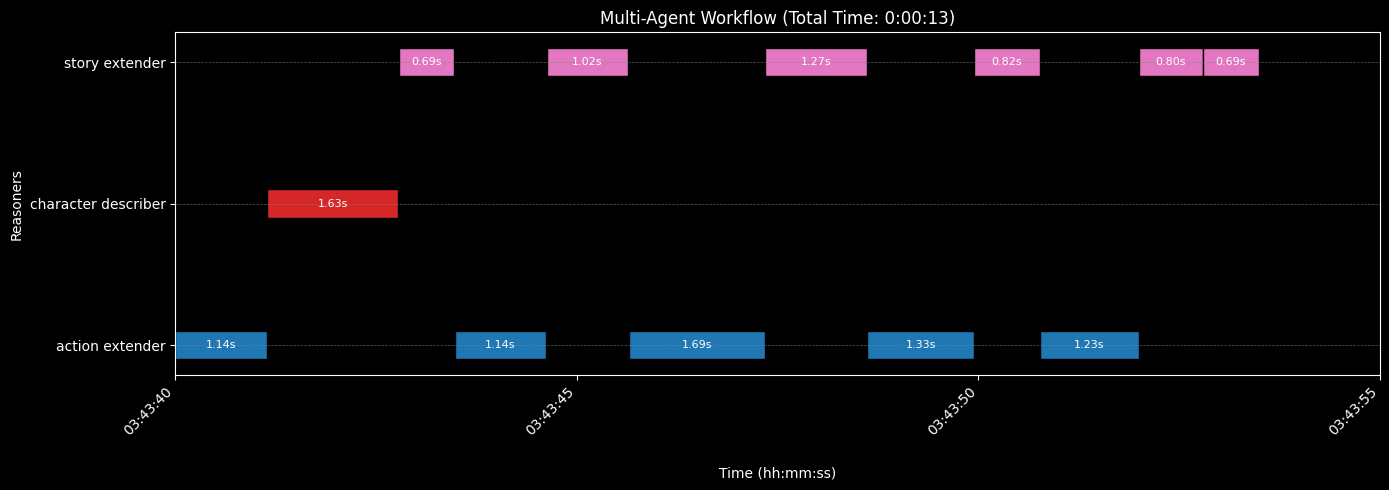

In [36]:
from brain.visualize import plot_workflow_matplotlib

lineage=brain.get_call_graph(runs[0]['session_id'])
fig=plot_workflow_matplotlib(lineage['lineage'])

## Modifiers

- Modifiers are objects that can be passed to modify the runtime behavior of the reasoner.
- Passed as keyword arguments when using the reasoner.
- Custom modifiers can be defined by inheriting from the `ModifierBase` class.
- Built-in modifiers include reasoning enhancers like CoT/IoT, guardrails, transformations, etc.

In [20]:
from brain.modifiers import COT as ChainOfThought

question = "How many R's are there in the word 'STRAWBERRY'?"
    
fut=[]
for _ in range(5):
    fut.append(brain.use(sample_reasoner.id,run_async=True)(
        system_prompt="You are an expert letter counter, answer this question",
        user_prompt=question,
    ))
answer_wo_mod = [f.result().answer for f in fut]
    
fut=[]
for _ in range(5):
    fut.append(brain.use(sample_reasoner.id,run_async=True,modifier=ChainOfThought())(
        system_prompt="You are an expert letter counter, answer this question",
        user_prompt=question,
    ))
answer_w_mod = [f.result().answer for f in fut]

print(f"Question: {question}\n\n"
f"Answers without modifier : {answer_wo_mod}\n"
f"Answers with CoT modifier: {answer_w_mod}")

Question: How many R's are there in the word 'STRAWBERRY'?

Answers without modifier : ['2', '2', '2', '2', '2']
Answers with CoT modifier: ['2', '2', '3', '3', '3']

In [ ]:
from random import choice
from typing import List


@brain.multi_agent(name="Story Builder with COT", tags=["storytelling", "quick-start"])
def story_builder_mod(start: str, characters: List[str], actions=List[str], n: int = 5):
    """
    Builds a story iteratively by introducing characters and progressing actions.

    Args:
        start (str): The starting line of the story.
        characters (List[str]): List of character names to introduce dynamically.
        n (int): Maximum number of iterations to build the story.

    Returns:
        dict: The final story, introduced characters, remaining characters, and final action.
    """
    story = start
    introduced_characters = []  # Track introduced characters
    remaining_characters = characters[:]  # Characters not yet introduced
    actions_proposed = []

    for _ in range(n - 1):
        # Step 1: Determine the next action
        # Use Chain of Thought modifier to decide the next action
        action = brain.use(action_extender.id,modifier=ChainOfThought(num_steps=2))(story=story, actions=actions)
        actions_proposed.append(action)

        if action.type == "introduce character" and remaining_characters:
            # Introduce a random character
            character_name = choice(remaining_characters)

            remaining_characters.remove(character_name)
            character_description = brain.use(character_describer.id)(
                name=character_name, story=story
            ).description
            
            # Use Chain of Thought modifier to extend the story
            story += brain.use(story_extender.id, modifier=ChainOfThought(num_steps=2))(
                story=story,
                action=f"Introduce {character_name}: {character_description}",
            ).story_next_lines
            introduced_characters.append(character_name)

        else:
            story += brain.use(story_extender.id)(
                story=story,
                action=f"Type:{action.type} Descprition{action.action_description}",
            ).story_next_lines

    # Conclude the story
    story += brain.use(story_extender.id)(
        story=story, action="end_story"
    ).story_next_lines

    # Return the final result
    return {
        "final_story": story,
        "introduced_characters": introduced_characters,
        "remaining_characters": remaining_characters,
        "final_action": actions_proposed,
    }


print(story_builder_mod(start, characters, actions=action, n=n)["final_story"])

Once upon a time, in a faraway land One sunny morning, as Bob set out on another adventure, he stumbled upon a 
mysterious map that promised to lead to an ancient treasure hidden deep within the enchanted woods.Intrigued, Bob 
followed the glowing lines of the map, each step revealing a shimmering trail of petals and twinkling lights. As he
ventured deeper into the woods, the air filled with the sound of laughter and the sweet scent of blooming flowers, 
suggesting he was not alone in this magical quest.Together, Bob and Charlie set off deeper into the woods, dancing 
through sunbeams and leaping over fallen branches, while Charlie sprinkled enchanted dust that made the flowers 
bloom brighter, guiding their way toward the treasure.As they walked, ethereal butterflies flitted around them, 
their wings shimmering in the golden sunlight, while a wise old owl perched on a nearby branch hooted softly, 
urging them on. Suddenly, a vibrant portal opened before them, pulsating with colors, hinting that the treasure was
not merely gold but a magical enchantment waiting to be uncovered.As Bob and Charlie listened in awe, the trees 
began to sway and harmonize, their voices weaving a melodious tapestry that filled the air. With each note sung by 
the flowers and trees, the heart of the forest stirred, awakening its ancient magic and casting a radiant glow 
throughout the whimsical realm.Emboldened by the forest's magic, Bob and Charlie stepped through the portal, 
discovering a realm where dreams intertwined with reality, filled with endless possibilities. With laughter and 
wonder in their hearts, they realized the true treasure was not gold, but the unbreakable bond of friendship forged
in the adventure itself. From that day onward, they became guardians of the enchanted woods, ensuring its magic 
lived on forever.

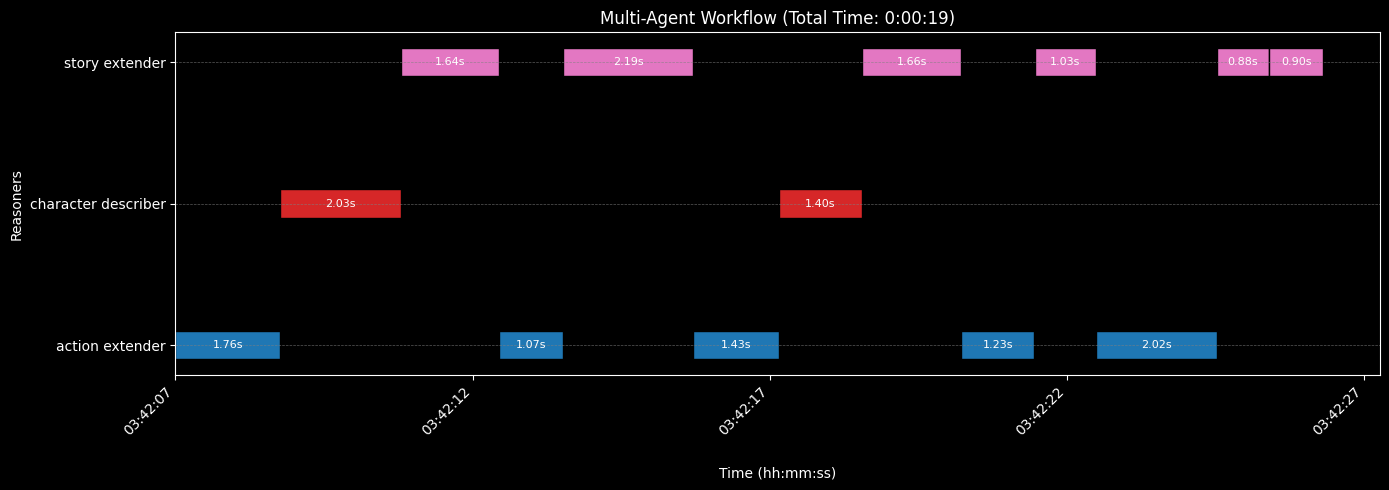

In [32]:
runs=brain.list_runs(print_table=False,return_data=True)
lineage=brain.get_call_graph(runs[0]['session_id'])
fig=plot_workflow_matplotlib(lineage['lineage'])